In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
from tqdm import tqdm
from geohash import encode
from scipy.stats import skew
# from sklearn.feature_extraction import FeatureHasher
# from sklearn.metrics.pairwise import cosine_similarity

%config InlineBackend.figure_format = 'retina' # set 'png' here when working on notebook
%matplotlib inline

data_dir='../../../data/'
cache_dir='../../../cache/'
flag=True

/usr/local/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## 加载数据

In [2]:
geo_precision=[7,8,9]

# 将经纬度geohash编码
def make_geohash(df,precision=[7]):
    for p in precision:
        df['geohash_%d'%p]=[encode(coor[0],coor[1],p) for coor in tqdm(df[['latitude','longitude']].values)]
    return df

# 提取时间结构信息
def make_struct_time(df):
    time_infos=[]
    for t in tqdm(df.time_stamp):
        _struct_time=time.strptime(t,'%Y-%m-%d %H:%M')
        time_infos.append([_struct_time.tm_hour+_struct_time.tm_min/60.,_struct_time.tm_hour,_struct_time.tm_wday])
    time_infos=pd.DataFrame(time_infos,columns=['time','hour','wday'])
    df=pd.concat((df,time_infos),axis=1)
    return df

# 按照强度降序排列wifi_bssid
def make_wifi_sorted(df,how='max',cache=False):
    cache_path=os.path.join(cache_dir,'加载数据','wifi_sorted_%d_%s.hdf'%(df.shape[0],how))
    if os.path.exists(cache_path) & flag & cache:
        result=pd.read_hdf(cache_path,'data')
    else:
        print('wifi_bssid %s排序中...'%how)
        def _sort_wifi(wifi_infos):
            d={}
            for i in wifi_infos.split(';'):
                infos=i.split('|')[:2] # ['bssid','strength']
                strength=int(infos[1])
                if infos[0] not in d:
                    d.update({infos[0]:[strength]})
                else:
                    d[infos[0]].append(strength)
            _agg=(lambda x:np.mean(x)) if how=='mean' else (lambda x:np.max(x))
            _serialize=lambda x:';'.join(['%s|%d'%(i[0],i[1]) for i in x]) # 序列化
            d=[(i[0],_agg(i[1])) for i in d.items()]
            return _serialize(sorted(d,key=lambda x:x[1],reverse=True))
        result=df.wifi_infos.apply(_sort_wifi)
        if cache:
            result.to_hdf(cache_path,'data')
    def _deserialize(x):
        # 反序列化
        result=[]
        for i in x.split(';'):
            ls=i.split('|')
            ls[1]=int(ls[1])
            result.append(ls)
        return result
    df['wifi_sorted_%s'%how]=result.apply(_deserialize)
    return df

# 加载数据
def load_data(file_path):
    df=pd.read_csv(file_path)
    df=make_geohash(df,geo_precision)
    df=make_struct_time(df)
    df=make_wifi_sorted(df,'max',True)
    return df

meta_df=pd.read_csv(os.path.join(data_dir,'训练数据-ccf_first_round_shop_info.csv'))
meta_df=make_geohash(meta_df,geo_precision)
train_df=load_data(os.path.join(data_dir,'训练数据-ccf_first_round_user_shop_behavior.csv'))
test_df=load_data(os.path.join(data_dir,'AB榜测试集-evaluation_public.csv'))

# 加入商铺信息（测试集此时还没有候选集，没有shop_id）
# meta_df.rename(columns={'geohash_6':'_geohash_6'},inplace=True)
train_df=pd.merge(train_df,meta_df[['shop_id','mall_id','category_id','price']],on='shop_id',how='left')
train_df['row_id']=train_df.index

100%|██████████| 483931/483931 [00:07<00:00, 61018.11it/s]


In [3]:
# # 标记出手机定位不可信的样本
# train_df['unbelievable']=(train_df.geohash_6!=train_df._geohash_6)*1
# _match=pd.merge(test_df[['row_id','geohash_6','mall_id']],meta_df[['_geohash_6','shop_id','mall_id']],on='mall_id',how='left')
# _match['equal']=(_match.geohash_6==_match._geohash_6)*1
# _match=_match[['row_id','equal']].groupby('row_id',as_index=False)['equal'].agg({'nb_equal':'sum'})
# _match=_match[_match.nb_equal==0]
# _match.rename(columns={'nb_equal':'unbelievable'},inplace=True)
# _match.unbelievable=1

# test_df=pd.merge(test_df,_match,on='row_id',how='left')
# test_df.fillna(0,inplace=True)

In [3]:
# 构造线下验证集
x_train=train_df[train_df.time_stamp<'2017-08-30 00:00']
x_val=train_df[train_df.time_stamp>='2017-08-30 00:00']

In [7]:
# # x_val & test_df同分布？
# def count_plot(df1,df2,key=None):
#     sns.set({'figure.figsize':(16,4)})
#     fig,axs=plt.subplots(1,2)
#     sns.countplot(data=df1,x=key,ax=axs[0])
#     sns.countplot(data=df2,x=key,ax=axs[1])

# merge_mall_id=lambda df:pd.merge(df,meta_df[['shop_id','mall_id']],on='shop_id',how='left')

# count_plot(x_val,test_df,'hour')
# count_plot(x_val,test_df,'wday')
# count_plot(x_val,test_df,'mall_id')

In [4]:
# 统计每个商场出现的wifi，并筛选掉出现在多个商场的wifi，如ChinaNet
mall_wifi=train_df.groupby('mall_id',as_index=False)['wifi_infos'].agg(lambda x:';'.join(x.wifi_infos))
ls=[]
for i in tqdm(mall_wifi.values):
    ls+=[(i[0],j.split('|')[0]) for j in i[1].split(';')]
mall_wifi=pd.DataFrame(ls,columns=['mall_id','wifi'])
wifi_mall_count=mall_wifi.groupby('wifi',as_index=False)['mall_id'].agg({'_count':lambda x:len(x.unique())})
wifi_mall_count.groupby('_count',as_index=False).count()

100%|██████████| 97/97 [00:10<00:00,  9.46it/s]


,_count,wifi
0,1,395574
1,2,3966
2,3,103
3,4,18
4,5,4
5,6,5
6,7,3
7,9,1
8,10,1
9,14,3


In [5]:
# 筛选掉出现在多个商场中的wifi
def wifi_filter(wifi_infos):
    result=pd.DataFrame([i.split('|')[:2] for i in wifi_infos.split(';')],columns=['wifi','strength'])
    result=pd.merge(result,wifi_mall_count[wifi_mall_count._count>3],on='wifi',how='left')
    result=result[result._count.isnull()]
    return ';'.join(['|'.join(i) for i in result[['wifi','strength']].values])

# 整合每个店铺对应的wi-fi信息
def make_aggregated_wifi(df):
    cache_path=os.path.join(cache_dir,'加载数据','aggregate_wifi_%d.hdf'% df.shape[0])
    if os.path.exists(cache_path) & flag:
        result=pd.read_hdf(cache_path,'data')
    else:
        result=df[['shop_id','wifi_infos']].groupby('shop_id',as_index=False).agg(lambda x:';'.join(x)) # x:pd.Series
        print('筛选wifi...')
        result.wifi_infos=result.wifi_infos.apply(wifi_filter)
        result=make_wifi_sorted(result,'max')
        result=make_wifi_sorted(result,'mean')
        result.to_hdf(cache_path,'data')
    return result

train_shop_wifi=make_aggregated_wifi(x_train)
test_shop_wifi=make_aggregated_wifi(train_df)

In [6]:
x_train.head()

,user_id,shop_id,time_stamp,longitude,latitude,wifi_infos,geohash_7,geohash_8,geohash_9,time,hour,wday,wifi_sorted_max,mall_id,category_id,price,row_id
0,u_376,s_2871718,2017-08-06 21:20,122.308291,32.088040,b_6396480|-67|false;b_41124514|-86|false;b_287...,wtwyx1q,wtwyx1qn,wtwyx1qnm,21.333333,21,6,"[[b_6396479, -55], [b_5857369, -55], [b_639648...",m_1409,c_38,42,0
1,u_376,s_2871718,2017-08-06 21:20,122.308162,32.087970,b_6396480|-67|false;b_56328155|-73|false;b_411...,wtwyx1q,wtwyx1qj,wtwyx1qjf,21.333333,21,6,"[[b_6396479, -57], [b_5857369, -57], [b_639648...",m_1409,c_38,42,1
2,u_1041,s_181637,2017-08-02 13:10,117.365255,40.638214,b_8006367|-78|false;b_2485110|-52|false;b_3005...,wx5rnty,wx5rntyy,wx5rntyyb,13.166667,13,2,"[[b_2485110, -52], [b_35013153, -56], [b_33503...",m_4079,c_30,40,2
3,u_1158,s_609470,2017-08-13 12:30,121.134451,31.197416,b_26250579|-73|false;b_26250580|-64|false;b_26...,wtw1krr,wtw1krr6,wtw1krr6j,12.500000,12,6,"[[b_30424471, -60], [b_26250580, -64], [b_2625...",m_6587,c_27,49,3
4,u_1654,s_3816766,2017-08-25 19:50,122.255867,31.351320,b_39004150|-66|false;b_39004148|-58|false;b_21...,wtwfq52,wtwfq524,wtwfq5248,19.833333,19,4,"[[b_39004148, -58], [b_39004150, -66], [b_1845...",m_3005,c_6,62,4


## EDA

In [37]:
print('训练集中单条记录最多有{}条wi-fi信息'.format(train_df.wifi_infos.apply(lambda x:len(x.split(';'))).max()))
print('测试集中单条记录最多有{}条wi-fi信息'.format(test_df.wifi_infos.apply(lambda x:len(x.split(';'))).max()))

训练集中单条记录最多有20条wi-fi信息
测试集中单条记录最多有10条wi-fi信息


In [7]:
# 计算两点之间距离
def cal_distance(lat1, lon1, lat2, lon2):
    dx = np.abs(lon1 - lon2)  # 经度差
    dy = np.abs(lat1 - lat2)  # 维度差
    b = (lat1 + lat2) / 2.0
    Lx = 6371004.0 * (dx / 57.2958) * np.cos(b / 57.2958)
    Ly = 6371004.0 * (dy / 57.2958)
    L = (Lx ** 2 + Ly ** 2) ** 0.5
    return L

In [14]:
# 计算手机的定位结果和店铺的坐标的偏差值
diff_dis=cal_distance(train_df['latitude_x'],train_df['longitude_x'],train_df['latitude_y'],train_df['longitude_y'])
diff_dis.describe()
# 大多数情况下手机定位误差并不大（最多几十米的范围），不过也存在很多严重漂移的情况

KeyError: 'latitude_x'

100%|██████████| 1138015/1138015 [00:01<00:00, 605226.24it/s]


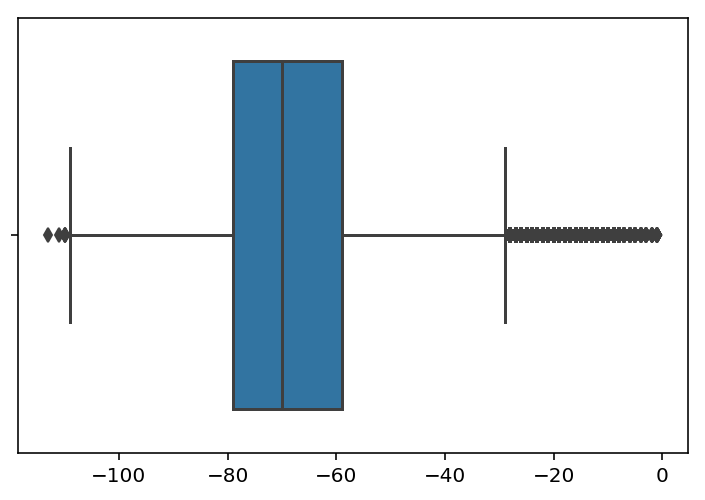

In [9]:
# 训练集wifi强度
wifi_strength=[]
for i in tqdm(train_df.wifi_sorted_max):
    wifi_strength+=[j[1] for j in i]
sns.boxplot(pd.Series(wifi_strength))

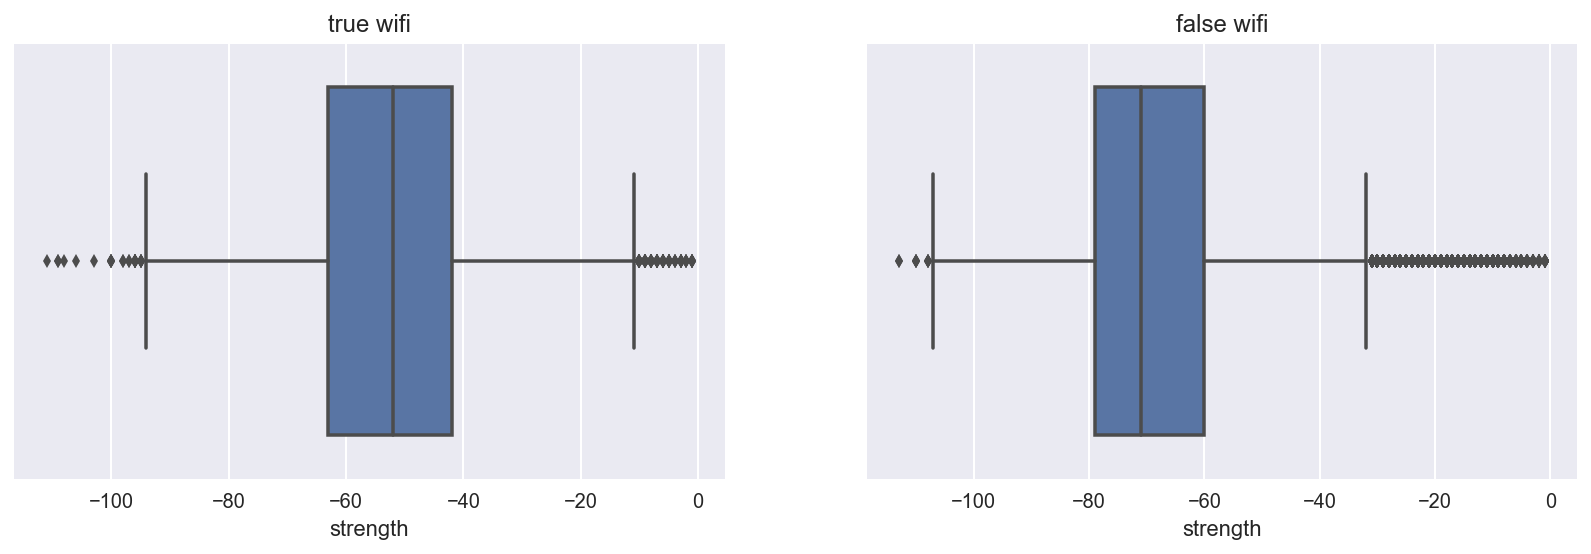

In [21]:
# 连接状态分别为true和false的wifi强度分布
wifi_strength=[]
for i in tqdm(pd.concat((train_df.wifi_infos,test_df.wifi_infos))):
    wifi_strength+=[j.split('|')[1:] for j in i.split(';')]
wifi_df=pd.DataFrame(wifi_strength,columns=['strength','connected'])
wifi_df.strength=wifi_df.strength.astype(int)
sns.set({'figure.figsize':(14,4)})
fig,axs=plt.subplots(1,2)
sns.boxplot(wifi_df.loc[wifi_df.connected=='true','strength'],ax=axs[0])
axs[0].set_title('true wifi')
sns.boxplot(wifi_df.loc[wifi_df.connected=='false','strength'],ax=axs[1])
axs[1].set_title('false wifi')

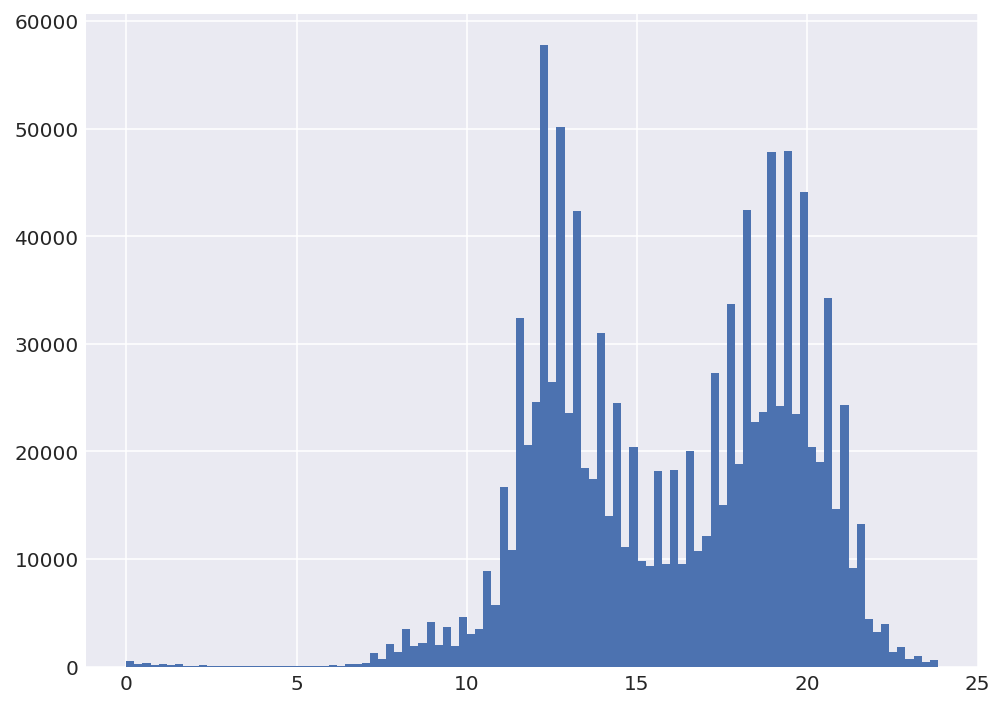

In [169]:
# 交易时间分布
train_df.time.hist(bins=100)

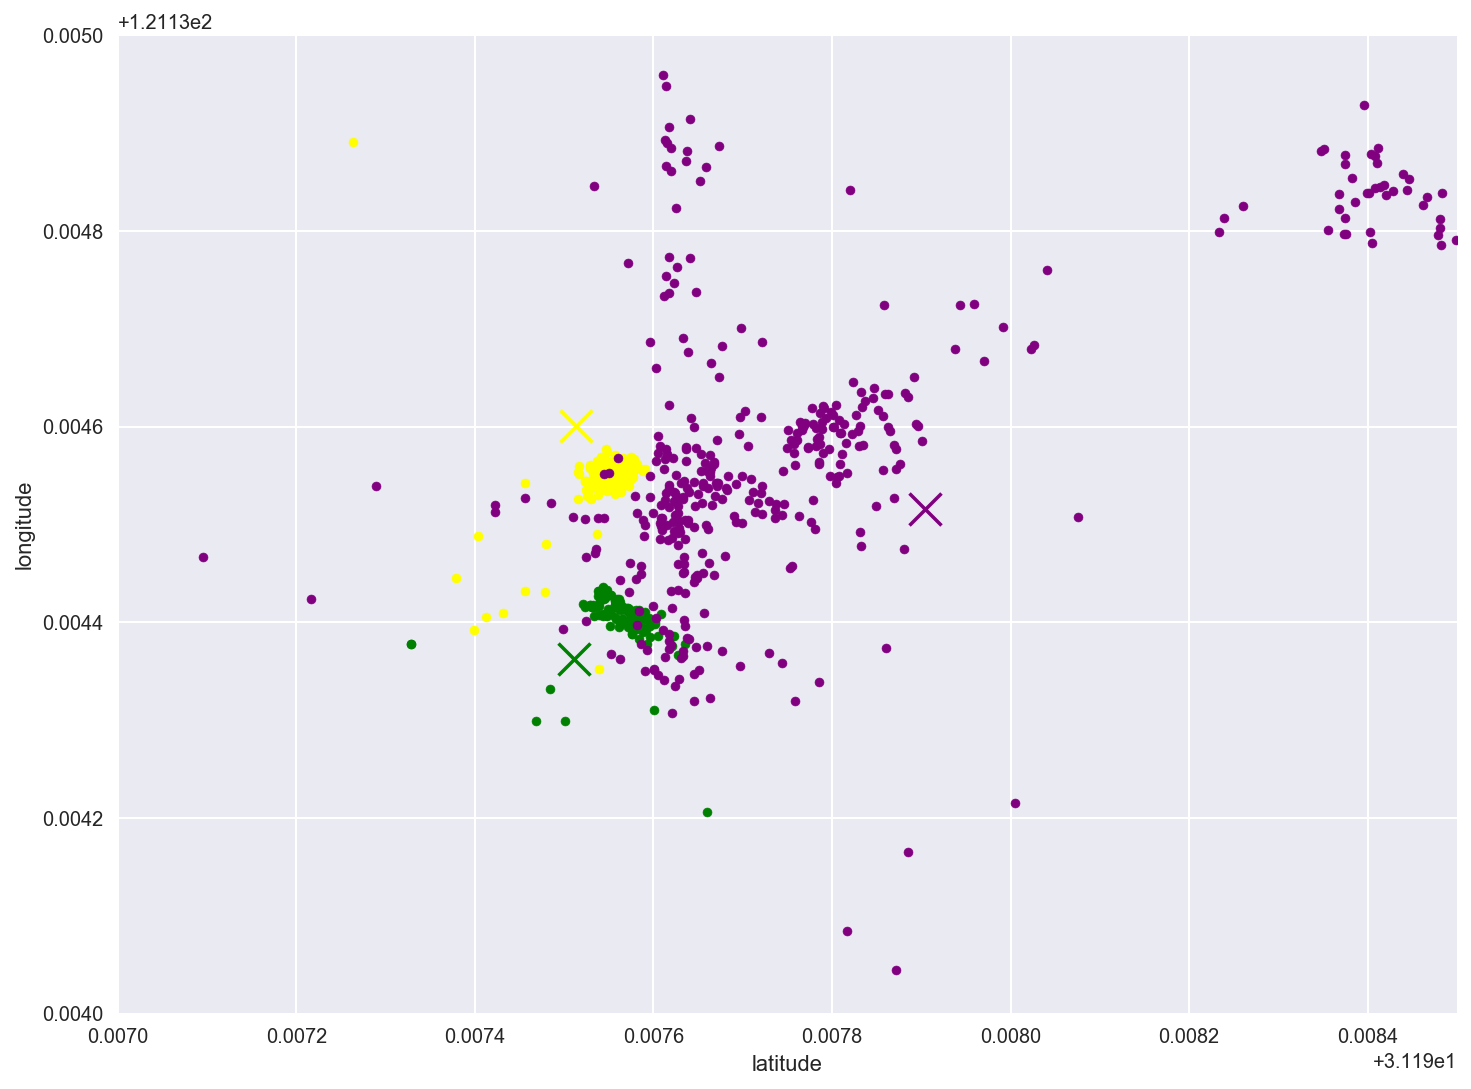

In [156]:
sns.set({'figure.figsize':(12,9)})
fig,ax=plt.subplots(1,1)
for shop_id,color in zip(['s_64615','s_133','s_22504'],['yellow','green','purple']):
    user_loc=train_df[train_df.shop_id==shop_id][['latitude','longitude']]
    user_loc.plot(kind='scatter',x='latitude',y='longitude',ax=ax,c=color,xlim=np.array((0.007,0.0085))+3.119e1,ylim=np.array((0.0040,0.0050))+1.2113e2)
    shop_loc=meta_df[meta_df.shop_id==shop_id][['latitude','longitude']]
    shop_loc.plot(kind='scatter',x='latitude',y='longitude',ax=ax,c=color,s=256,marker='x')

## 构造候选shop_id集

In [8]:
# 构造候选集。考虑：用户历史信息、手机+wi-fi定位区域信息

# 7 12831138 98.06315205712107%
# 8 3983675 96.50237426778968%
# 9 1462770 89.19794807805621%
def get_nearby_shops_by_geo(train,test,geo_col='geohash_8'):
    print('加入geohash定位点附近商铺...')
    cache_path=os.path.join(cache_dir,'构造候选','nearby_shops_%d_%s.hdf'%(train.shape[0] * test.shape[0],geo_col))
    if os.path.exists(cache_path) & flag:
        result=pd.read_hdf(cache_path,'data')
    else:
        shop_locs=train[['mall_id',geo_col,'shop_id']].drop_duplicates() # 减少匹配次数
        result=pd.merge(test[['row_id','mall_id',geo_col]],shop_locs,on=['mall_id',geo_col],how='left')
        result=result[['row_id','shop_id']]
        result.to_hdf(cache_path,'data')
    return result

# 5 231w 94.3%
# 6 212w 94%
# 7 196w 93.8%
# 8 181w 93%
# 10 155w 91%
def get_nearby_shops_by_wifi(df,shop_wifi,geo_col='geohash_7'):
    print('加入wi-fi定位点附近商铺...')
    cache_path=os.path.join(cache_dir,'构造候选','nearby_shops_%d_wifi.hdf'%df.shape[0])
    if os.path.exists(cache_path) & flag:
        result=pd.read_hdf(cache_path,'data')
    else:
        result=pd.merge(shop_wifi,meta_df[['shop_id','mall_id',geo_col]],on='shop_id',how='left')
        result=pd.merge(df[['row_id','mall_id',geo_col,'wifi_sorted_max']],result,on=['mall_id',geo_col],how='inner')
        result=result[['row_id','shop_id','wifi_sorted_max_x','wifi_sorted_max_y']]
        result.reset_index()
        # wi-fi交集数
        _set=lambda x:set([i[0] for i in x])
        result['_count']=[len(_set(i[0])&_set(i[1])) for i in tqdm(result[['wifi_sorted_max_x','wifi_sorted_max_y']].values)]
        result.to_hdf(cache_path,'data')
    result=result[['row_id','shop_id']].loc[result._count>=7]
    return result

# def get_shops_by_mall_wifi(df,shop_wifi):
#     print('根据mall和wifi匹配商铺...')
#     df=df[df.unbelievable==1]
#     cache_path=os.path.join(cache_dir,'构造候选','shops_%d_mall_wifi.hdf'%df.shape[0])
#     if os.path.exists(cache_path) & flag:
#         result=pd.read_hdf(cache_path,'data')
#     else:        
#         result=pd.merge(shop_wifi,meta_df[['shop_id','mall_id']],on='shop_id',how='left')
#         result=pd.merge(df[['row_id','mall_id','wifi_sorted_max']],result,on=['mall_id'],how='inner')
#         result=result[['row_id','shop_id','wifi_sorted_max_x','wifi_sorted_max_y']]
#         result.reset_index()
#         # wi-fi交集数
#         _set=lambda x:set([i[0] for i in x])
#         result['_count']=[len(_set(i[0])&_set(i[1])) for i in tqdm(result[['wifi_sorted_max_x','wifi_sorted_max_y']].values)]
#         result.to_hdf(cache_path,'data')
#     result=result.sort_values('_count').groupby('row_id',as_index=False).tail(3)
#     result=result[['row_id','shop_id']]
# #     result=result[['row_id','shop_id']].loc[result._count>=7]
#     return result

def get_user_history_shops(train,test):
    print('加入用户历史商铺...')
    cache_path=os.path.join(cache_dir,'构造候选','user_history_shops_%d.hdf'%(train.shape[0] * test.shape[0]))
    if os.path.exists(cache_path) & flag:
        result=pd.read_hdf(cache_path,'data')
    else:
        user_history=train[['mall_id','user_id','shop_id']].drop_duplicates() # 减少匹配次数
        result=pd.merge(test[['row_id','mall_id','user_id']],user_history,on=['mall_id','user_id'],how='left')
        result=result[['row_id','shop_id']]
        result.to_hdf(cache_path,'data')
    return result

def make_candidate_shops(train,test,shop_wifi=None,geo_col=None):
    if 'row_id' not in test.columns:
        test['row_id']=test.index
    # 构造候选shop_id集
    nearby_shops_by_geo=get_nearby_shops_by_geo(train,test,geo_col)
    nearby_shops_by_wifi=get_nearby_shops_by_wifi(test,shop_wifi)
#     shops_by_mall_wifi=get_shops_by_mall_wifi(test,shop_wifi)
    user_history_shops=get_user_history_shops(train,test)
    df_set=(nearby_shops_by_geo,nearby_shops_by_wifi,user_history_shops)
    candidate_shops=pd.concat(df_set).drop_duplicates()
    candidate_shops.dropna(inplace=True)
    # 计算覆盖率
    print('共有{}条候选样本'.format(candidate_shops.shape[0]))
    if 'shop_id' in test.columns:
        print('覆盖率{}%'.format(pd.merge(test[['row_id','shop_id']],candidate_shops,on=['row_id','shop_id'],how='inner').shape[0]*100./test.shape[0]))
    print('构造完成...')
    return candidate_shops
    
print('构造训练候选集...')
train_candidate=make_candidate_shops(x_train,x_train,train_shop_wifi,'geohash_9')
train_candidate=pd.concat((train_candidate,x_train[['row_id','shop_id']])).drop_duplicates()
print('构造测试候选集...')
test_candidate=make_candidate_shops(train_df,test_df,test_shop_wifi,'geohash_8')
print('构造验证候选集...')
val_candidate=make_candidate_shops(x_train,x_val,train_shop_wifi,'geohash_8')

构造训练候选集...
加入geohash定位点附近商铺...
加入wi-fi定位点附近商铺...
加入用户历史商铺...
共有8267458条候选样本
覆盖率100.0%
构造完成...
构造测试候选集...
加入geohash定位点附近商铺...
加入wi-fi定位点附近商铺...
加入用户历史商铺...
共有7419464条候选样本
构造完成...
构造验证候选集...
加入geohash定位点附近商铺...
加入wi-fi定位点附近商铺...
加入用户历史商铺...
共有944061条候选样本
覆盖率98.06151542664182%
构造完成...


In [12]:
# 利用多分类模型的结果构造二分类模型的候选集
def make_candidate_shops_by_multi(cache_suffix,nb_candidates=5):
    candidates=[]
    probas=[]
    for mall_id in tqdm(meta_df.mall_id.unique()):
        fname=os.path.join(cache_dir,'multi','{}_{}.hdf'.format(mall_id,cache_suffix))
        cache_file=pd.read_hdf(fname,'data')
        for idx,row in cache_file.iterrows():
            for i in row[-nb_candidates:]:
                candidates.append((idx,i))
        cache_file=pd.read_hdf(fname,'proba')
        probas+=list(cache_file.values[:,-nb_candidates:].flatten())
    result=pd.DataFrame(candidates,columns=['row_id','shop_id'])
    result['proba']=probas
    return result

train_candidate=make_candidate_shops_by_multi('train',nb_candidates=5)
val_candidate=make_candidate_shops_by_multi('val',nb_candidates=7)
test_candidate=make_candidate_shops_by_multi('test',nb_candidates=7)

100%|██████████| 97/97 [01:10<00:00,  1.21it/s]


In [13]:
# 计算覆盖率
print(pd.merge(train_candidate,x_train[['shop_id','row_id']],on=['shop_id','row_id'],how='inner').shape[0]/x_train.shape[0])
print(pd.merge(val_candidate,x_val[['shop_id','row_id']],on=['shop_id','row_id'],how='inner').shape[0]/x_val.shape[0])
# 5:0.972682818050047
# 7:0.9780984692821076
# history+7:0.981124862617671

0.9971196967357803
0.9780984692821076


## 构造训练/测试基础样本

In [14]:
train_basic=pd.merge(x_train,train_candidate,on='row_id',how='left')
train_basic['label']=(train_basic['shop_id_x']==train_basic['shop_id_y'])*1
train_basic.drop('shop_id_x',axis=1,inplace=True)
train_basic.rename(columns={'shop_id_y':'shop_id'},inplace=True)
train_basic=pd.merge(train_basic,train_shop_wifi,on='shop_id',how='left')

In [15]:
val_basic=pd.merge(x_val,val_candidate,on='row_id',how='left')
val_basic['label']=(val_basic['shop_id_x']==val_basic['shop_id_y'])*1
val_basic.drop('shop_id_x',axis=1,inplace=True)
val_basic.rename(columns={'shop_id_y':'shop_id'},inplace=True)
val_basic=pd.merge(val_basic,train_shop_wifi,on='shop_id',how='left')

In [12]:
test_basic=pd.merge(test_df,test_candidate,on='row_id',how='left')
test_basic=pd.merge(test_basic,test_shop_wifi,on='shop_id',how='left')
test_basic=pd.merge(test_basic,meta_df[['shop_id','category_id','price']],on='shop_id',how='left')

In [13]:
train_basic.head()

,user_id,time_stamp,longitude,latitude,wifi_infos_x,geohash_7,geohash_8,geohash_9,time,hour,...,wifi_sorted_max_x,mall_id,category_id,price,row_id,shop_id,label,wifi_infos_y,wifi_sorted_max_y,wifi_sorted_mean
0,u_376,2017-08-06 21:20,122.308291,32.08804,b_6396480|-67|false;b_41124514|-86|false;b_287...,wtwyx1q,wtwyx1qn,wtwyx1qnm,21.333333,21,...,"[[b_6396479, -55], [b_5857369, -55], [b_639648...",m_1409,c_38,42,0,s_2871718,1,b_6396480|-67;b_41124514|-86;b_28723327|-90;b_...,"[[b_26748506, -26], [b_6396479, -43], [b_58573...","[[b_50744804, -49], [b_5857369, -53], [b_63964..."
1,u_376,2017-08-06 21:20,122.308291,32.08804,b_6396480|-67|false;b_41124514|-86|false;b_287...,wtwyx1q,wtwyx1qn,wtwyx1qnm,21.333333,21,...,"[[b_6396479, -55], [b_5857369, -55], [b_639648...",m_1409,c_38,42,0,s_5917,0,b_28081413|-61;b_28723327|-71;b_56326765|-61;b...,"[[b_20517758, -20], [b_8764723, -27], [b_87647...","[[b_28633758, -30], [b_20973039, -32], [b_1057..."
2,u_376,2017-08-06 21:20,122.308291,32.08804,b_6396480|-67|false;b_41124514|-86|false;b_287...,wtwyx1q,wtwyx1qn,wtwyx1qnm,21.333333,21,...,"[[b_6396479, -55], [b_5857369, -55], [b_639648...",m_1409,c_38,42,0,s_3699,0,b_56326189|-61;b_30230712|-62;b_25137940|-51;b...,"[[b_30230709, -15], [b_30230710, -25], [b_5632...","[[b_35548532, -32], [b_41781150, -35], [b_1877..."
3,u_376,2017-08-06 21:20,122.308291,32.08804,b_6396480|-67|false;b_41124514|-86|false;b_287...,wtwyx1q,wtwyx1qn,wtwyx1qnm,21.333333,21,...,"[[b_6396479, -55], [b_5857369, -55], [b_639648...",m_1409,c_38,42,0,s_1219090,0,b_29949764|-88;b_47935498|-49;b_16836443|-53;b...,"[[b_20435342, -29], [b_8902417, -34], [b_71303...","[[b_8902417, -34], [b_7130341, -38], [b_299508..."
4,u_376,2017-08-06 21:20,122.308291,32.08804,b_6396480|-67|false;b_41124514|-86|false;b_287...,wtwyx1q,wtwyx1qn,wtwyx1qnm,21.333333,21,...,"[[b_6396479, -55], [b_5857369, -55], [b_639648...",m_1409,c_38,42,0,s_1347287,0,b_50131463|-60;b_5577434|-86;b_14940702|-89;b_...,"[[b_15524738, -25], [b_55087776, -33], [b_5552...","[[b_15524738, -41], [b_55087776, -43], [b_5552..."


## 加入特征

In [8]:
def add_shop_count(df1,df2):
    shop_count=df1.groupby('shop_id',as_index=False)['shop_id'].agg({'shop_count':'count'})
    result=pd.merge(df2,shop_count,on='shop_id',how='left')
    return result

def add_mall_heat(df1,df2):
    mall_heat=df1.groupby('mall_id',as_index=False)['mall_id'].agg({'mall_heat':'count'})
    result=pd.merge(df2,mall_heat,on='mall_id',how='left')
    return result

# def add_shop_count_with_time(df1,df2):
#     shop_count_with_time=df1.groupby(['shop_id','hour'],as_index=False)['shop_id'].agg({'shop_count_with_time':'count'})
#     result=pd.merge(df2,shop_count_with_time,on=['shop_id','hour'],how='left')
#     return result

# def add_mall_heat_with_time(df1,df2):
#     mall_heat_with_time=df1.groupby(['mall_id','hour'],as_index=False)['mall_id'].agg({'mall_heat_with_time':'count'})
#     result=pd.merge(df2,mall_heat_with_time,on=['mall_id','hour'],how='left')
#     return result

# def add_user_shop_frequency(df1,df2):
#     user_shop_frequency=df1.groupby(['user_id','shop_id'],as_index=False)['shop_id'].agg({'user_shop_frequency':'count'})
#     result=pd.merge(df2,user_shop_frequency,on=['user_id','shop_id'],how='left')
#     return result

# def add_user_mall_frequency(df1,df2):
#     user_mall_frequency=df1.groupby(['user_id','mall_id'],as_index=False)['mall_id'].agg({'user_mall_frequency':'count'})
#     result=pd.merge(df2,user_mall_frequency,on=['user_id','mall_id'],how='left')
#     return result

def add_user_power(df1,df2):
    user_power=df1.groupby(['user_id'],as_index=False)['price'].agg({'mean_power':'mean'})
    result=pd.merge(df2,user_power,on=['user_id'],how='left')
    return result

def add_category_time(df1,df2):
    category_time=df1[['category_id','time']].groupby(['category_id'],as_index=False)['time'].agg({'category_time':'mean'})
    result=pd.merge(df2,category_time,on='category_id',how='left')
    return result

def add_distance(df):
    result=pd.merge(df,meta_df[['shop_id','longitude','latitude']],on='shop_id',how='left')
    result['distance']=cal_distance(result['latitude_x'],result['longitude_x'],result['latitude_y'],result['longitude_y'])
    return result

def add_distance_rank(df):
    idx=df.index
    result=df.reset_index().sort_values(['row_id','distance'])
    result['dis_rank']=range(0,result.shape[0])
    min_rank=result.groupby('row_id',as_index=False)['dis_rank'].agg({'min_rank':'min'})
    result=pd.merge(result,min_rank,on='row_id',how='left')
    result['dis_rank']=result['dis_rank']-result['min_rank']
    result.index=result['index']
    result=result.loc[idx].drop(['min_rank','index'],axis=1)
    return result

##################################Wi-Fi特征##################################

def apk(actual, predicted, k=10, on_actual=True):
    """
    actual : A list of elements that are to be predicted (order doesn't matter)
    predicted : A list of predicted elements (order does matter)
    """
    if len(predicted)>k:
        predicted = predicted[:k]
    if on_actual and len(actual)>k:                             
        actual = actual[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def add_wifi_apk(df,k=10,on_actual=True,how='max'):
    name='wifi_apk_{}_{}_{}'.format(how,k,on_actual*1)
    cache_path=os.path.join(cache_dir,'构造特征/wifi_apk','{}_{}.hdf'.format(name,df.shape[0]))
    if os.path.exists(cache_path) & flag:
        result=pd.read_hdf(cache_path,'data')
    else:
        apks=[]
        col='wifi_sorted_max_y' if how=='max' else 'wifi_sorted_mean'
        _list=lambda x:[i[0] for i in x[:k]]
        for i in tqdm(df[['wifi_sorted_max_x',col]].values):
            if type(i[0])==list and type(i[1])==list:
                apks.append(apk(_list(i[1]),_list(i[0]),k,on_actual))
            else:
                apks.append(0)
        result=pd.Series(apks)
        result.to_hdf(cache_path,'data')
    df[name]=result
    return df

def add_wifi_diff(df,how='max'):
    cache_path=os.path.join(cache_dir,'构造特征/wifi_diff','wifi_diff_{}_{}.hdf'.format(how,df.shape[0]))
    if os.path.exists(cache_path) & flag:
        result=pd.read_hdf(cache_path,'data')
    else:
        diffs=[]
        col='wifi_sorted_max_y' if how=='max' else 'wifi_sorted_mean'
        for i in tqdm(df[['wifi_sorted_max_x',col]].values):
            if type(i[0])==list and type(i[1])==list:
                large_sum=large_num=less_sum=less_num=0
                d1=dict(i[0])
                d2=dict(i[1])
                intersection_keys=d1.keys()&d2.keys()
                for key in intersection_keys:
                    value1=d1[key]
                    value2=d2[key]
                    if value1>=value2:
                        large_sum+=(value1-value2) # 越大越好
                        large_num+=1
                    else:
                        less_sum+=(value2-value1) # 越小越好
                        less_num+=1
                large_sum=large_sum/large_num if large_num>0 else 0
                less_sum=less_sum/less_num if less_num>0 else 0
                diffs.append([large_sum,large_num,less_sum,less_num])
            else:
                diffs.append([0]*4)
        cols=['{}_{}'.format(i,how) for i in ['large_sum','large_num','less_sum','less_num']]
        result=pd.DataFrame(diffs,columns=cols)
        result.to_hdf(cache_path,'data')
    df=pd.concat((df,result),axis=1)
    return df

def add_wifi_rfd(df,how='max'):
    cache_path=os.path.join(cache_dir,'构造特征/wifi_rfd','wifi_rfd_{}_{}.hdf'.format(how,df.shape[0]))
    if os.path.exists(cache_path) & flag:
        result=pd.read_hdf(cache_path,'data')
    else:
        rfds=[]
        col='wifi_sorted_max_y' if how=='max' else 'wifi_sorted_mean'
        _set=lambda x:set([i[0] for i in x])
        for i in tqdm(df[['wifi_sorted_max_x',col]].values):
            if type(i[0])==list and type(i[1])==list:
                d1=dict(i[0])
                d2=dict(i[1])
                intersection_keys=d1.keys()&d2.keys()
                nb_intersection=len(intersection_keys) # 交集数
                if nb_intersection>0:
                    nb_union=len(d1.keys()|d2.keys()) # 并集数
                    jaccard=np.log1p(nb_intersection/nb_union)
                    l1=l2=0
                    for key in intersection_keys:
                        value1=d1[key]
                        value2=d2[key]
                        l1+=np.abs(value1-value2)
                        l2+=(value1-value2)**2
                    p=1 # Jaccard系数
                    rfd1=l1/(nb_intersection+p*jaccard)
                    rfd2=np.sqrt(l2)/(nb_intersection+p*jaccard)
                    rfds.append([rfd1,rfd2])
                    continue
            rfds.append([111111]*2) # 最大距离
        cols=['{}_{}'.format(i,how) for i in ['rfd1','rfd2']]
        result=pd.DataFrame(rfds,columns=cols)
        result.to_hdf(cache_path,'data')
    df=pd.concat((df,result),axis=1)
    return df

def add_feats(df1,df2):
    result=add_shop_count(df1,df2)
    result=add_mall_heat(df1,result)
#     result=add_shop_count_with_time(df1,result)
#     result=add_mall_heat_with_time(df1,result)
#     result=add_user_shop_frequency(df1,result)
#     result=add_user_mall_frequency(df1,result)
    result=add_user_power(df1,result)
    result=add_category_time(df1,result)
    result=add_distance(result)
    result=add_distance_rank(result)
    for how in ['max']:
        result=add_wifi_apk(result,k=4,how=how)
        result=add_wifi_apk(result,k=10,how=how)
    result=add_wifi_diff(result,how='mean')
    result=add_wifi_rfd(result,how='mean')
    result['mean_power'].fillna(np.median(meta_df.price),inplace=True)
#     result.fillna(0,inplace=True)
    return result

flag=True
print('加入训练集特征...')
train_feat=add_feats(x_train,train_basic)
print('加入测试集特征...')
test_feat=add_feats(train_df,test_basic)
print('加入验证集特征...')
val_feat=add_feats(x_train,val_basic)

加入训练集特征...
加入测试集特征...
加入验证集特征...


In [22]:
# 后处理
feat_cols=['time_gap','mean_power_gap','shop_heat']
feat_cols+=['wifi_apk_{}_{}'.format(how,i) for i in ['4_1','10_1'] for how in ['max']]
feat_cols+=['{}_{}'.format(i,how) for i in ['large_sum','large_num','less_sum','less_num'] for how in ['mean']]
feat_cols+=['{}_{}'.format(i,how) for i in ['rfd1','rfd2'] for how in ['mean']]
feat_cols+=['distance']

def post_precess(df):
    df['shop_heat']=df['shop_count']/df['mall_heat']
#     df['shop_heat_with_time']=df['shop_count_with_time']/df['mall_heat_with_time']
#     df['user_shop_ratio']=df['user_shop_frequency']/df['user_mall_frequency']
    df['mean_power_gap']=df['price']-df['mean_power']
    df['time_gap']=np.abs(df['time']-df['category_time'])
    feats=df[feat_cols]
    feats.fillna(0,inplace=True)
    label=df.label if 'label' in df.columns else None
    return feats,label

train,label=post_precess(train_feat)
test,none=post_precess(test_feat)
val,val_label=post_precess(val_feat)

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:2842: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [40]:
# 特征有没有区分度？
pd.concat((val_feat[feat_cols],val_label),axis=1).rename(columns={0:'label'}).groupby('label').median()

,time_gap,mean_power_gap,shop_heat,wifi_apk_max_4_1,wifi_apk_max_10_1,large_sum_mean,large_num_mean,less_sum_mean,less_num_mean,rfd1_mean,rfd2_mean,distance,proba
label,,,,,,,,,,,,,
0,3.054142,0.0,0.012777,0.00,0.0000,7.000000,2,4.0,1,15.248018,7.486343,52.615878,0.000806
1,3.054142,0.0,0.021369,0.25,0.2375,3.571429,5,4.2,4,4.478257,1.795828,28.486020,0.981144


  0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
100%|██████████| 13/13 [00:02<00:00,  5.88it/s]


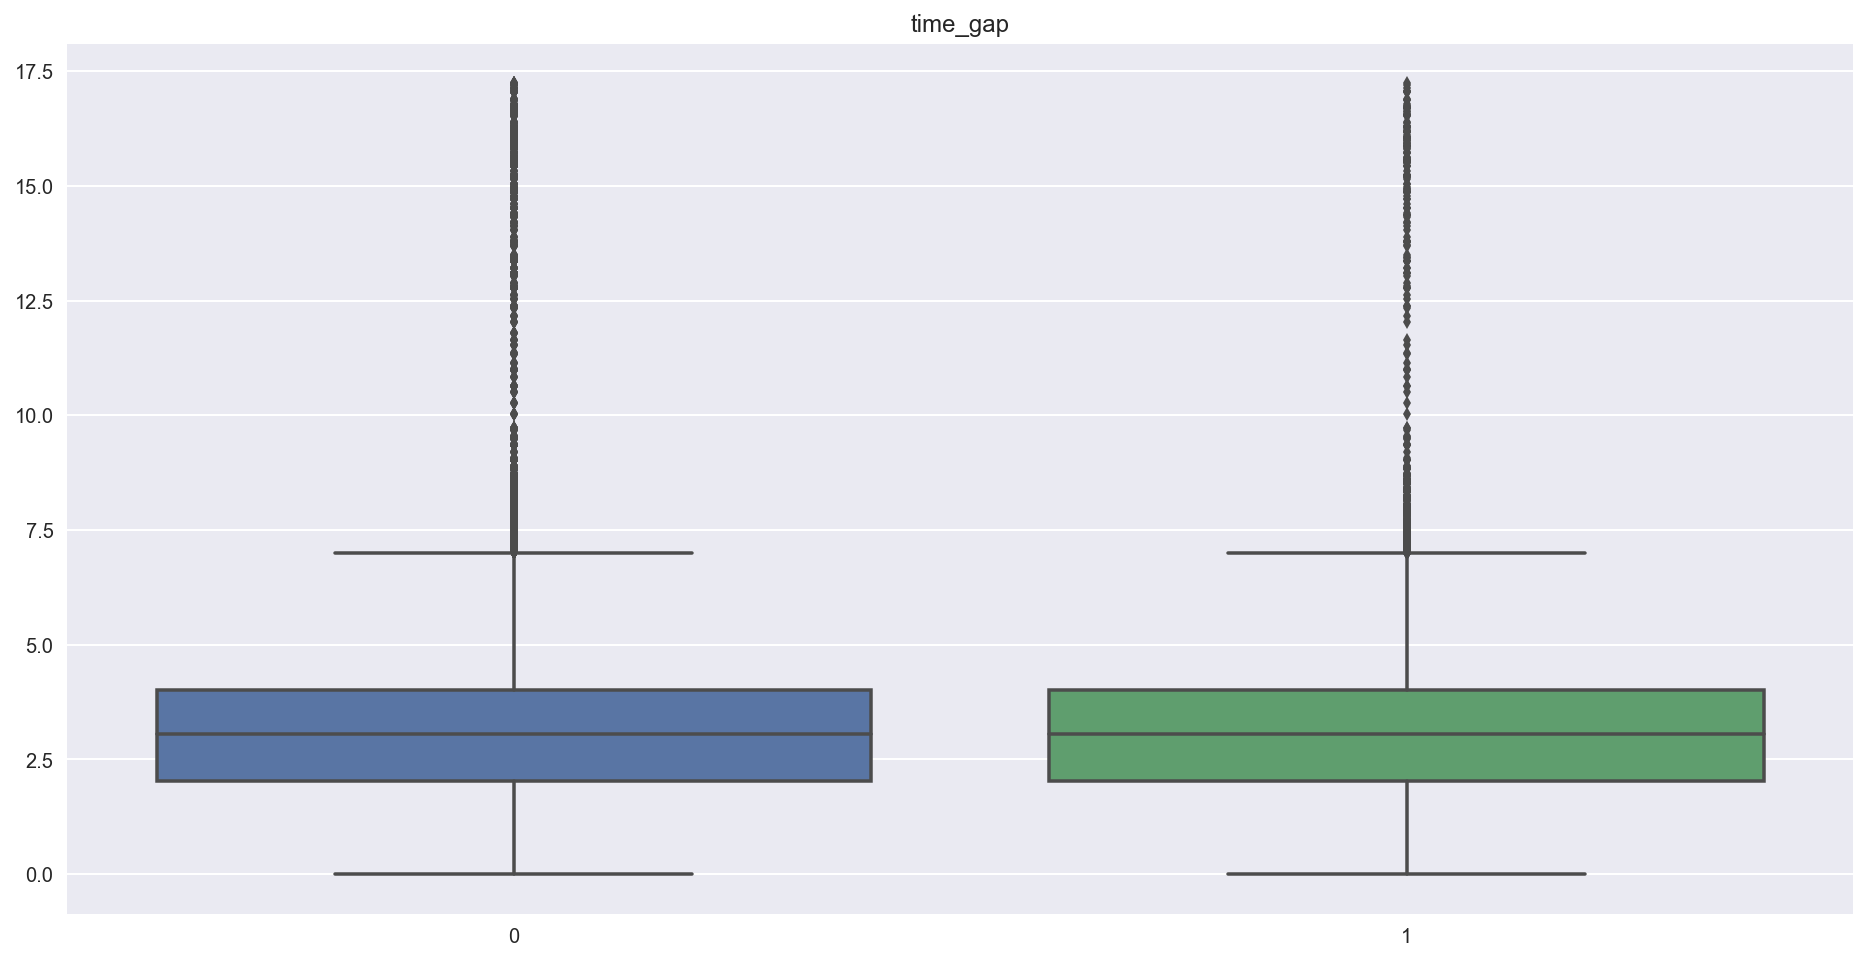

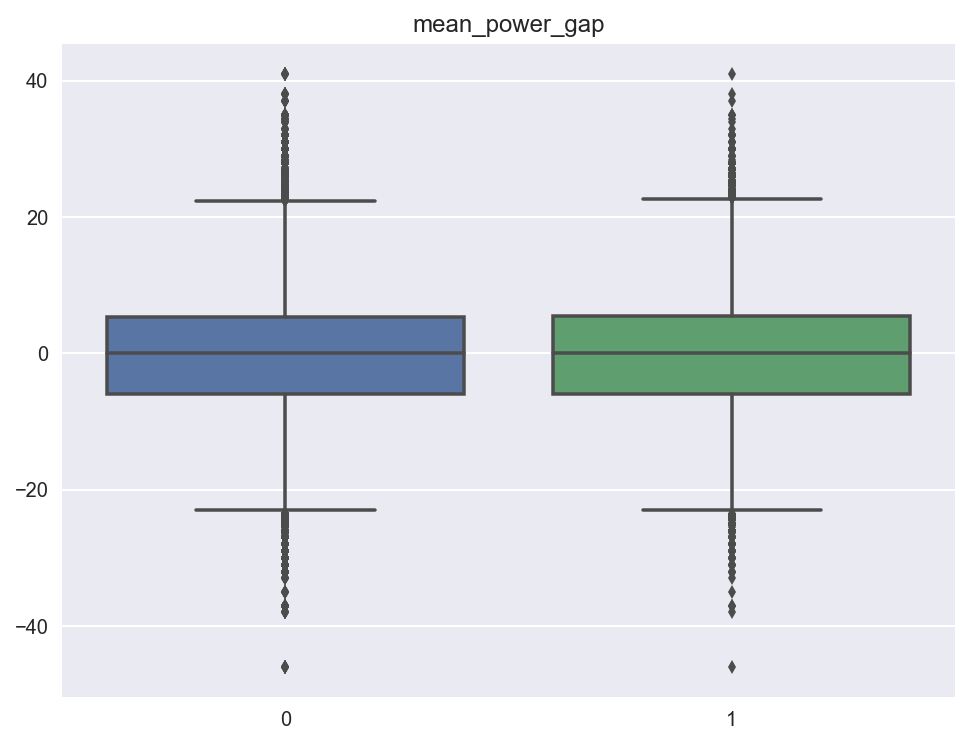

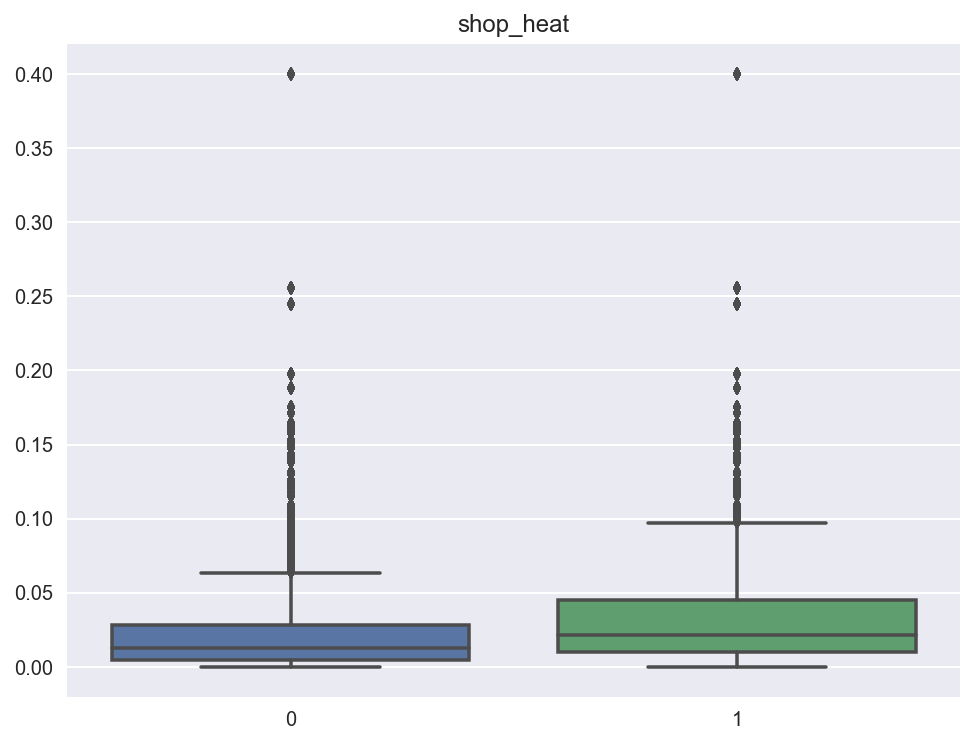

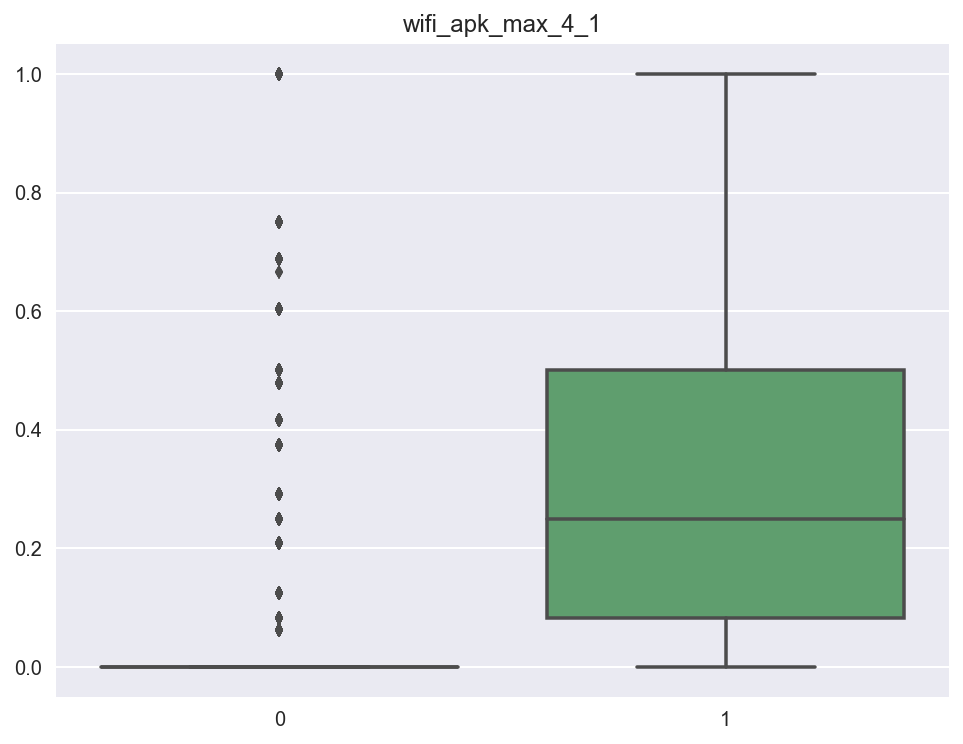

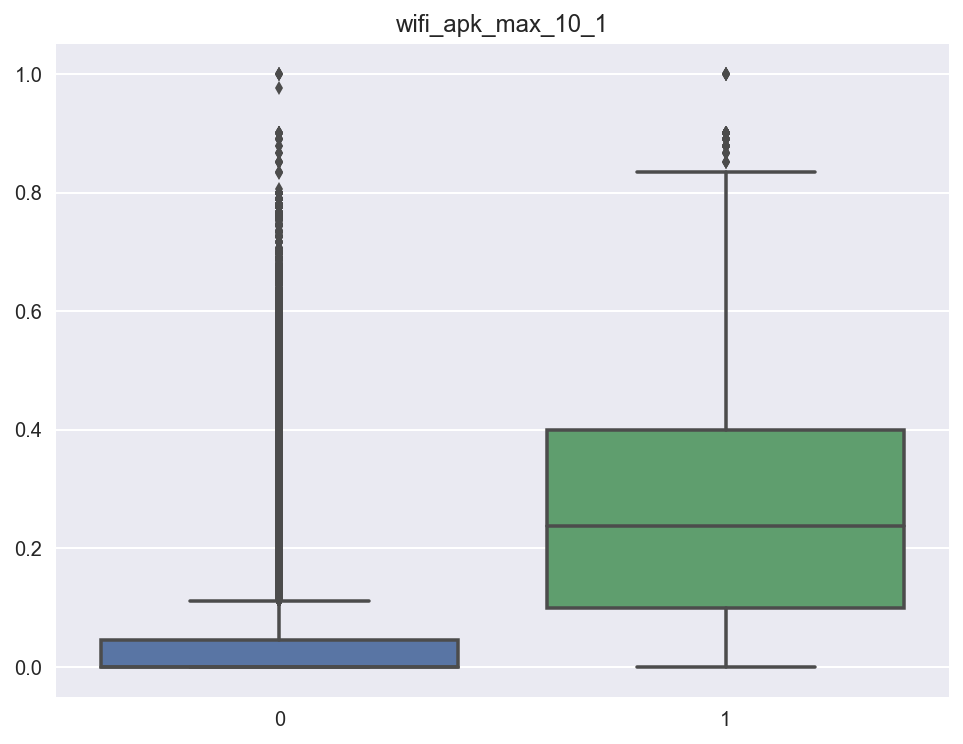

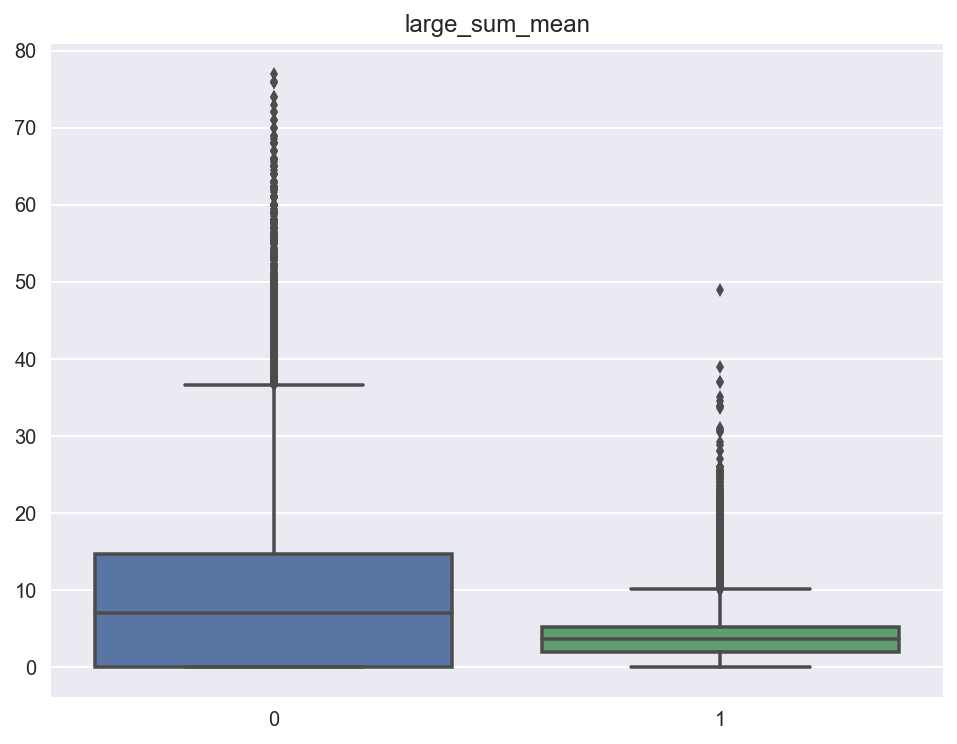

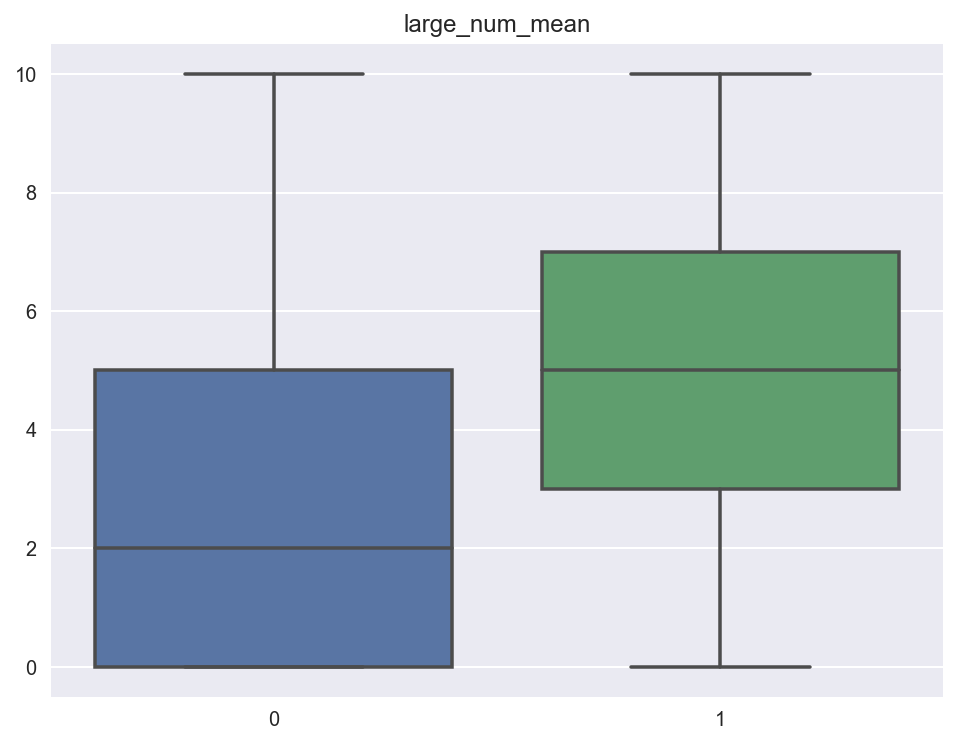

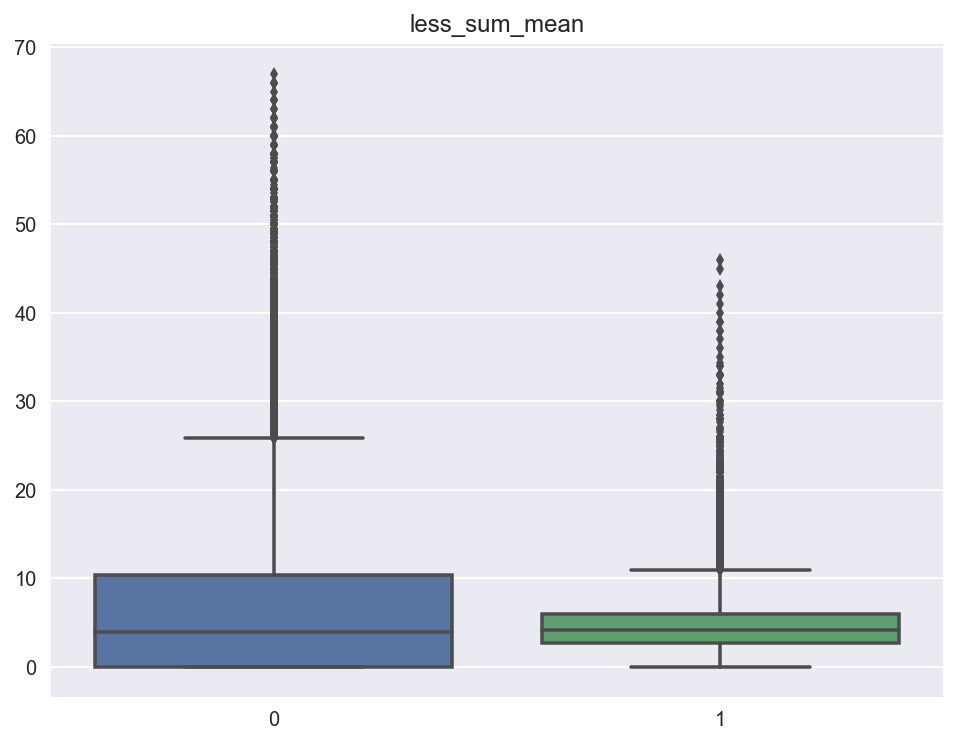

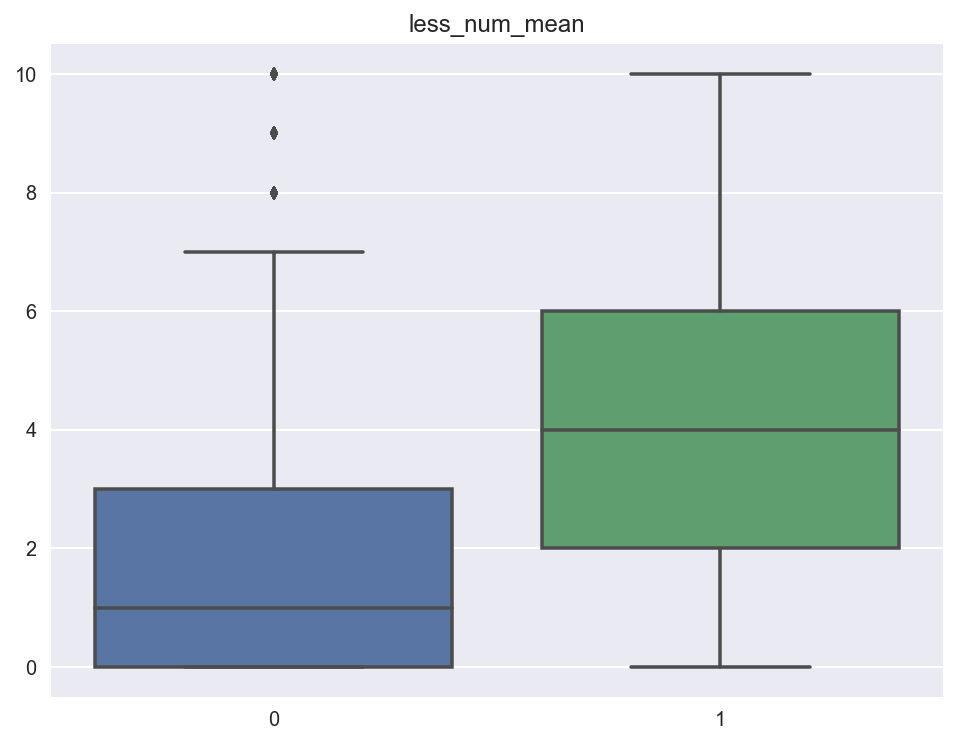

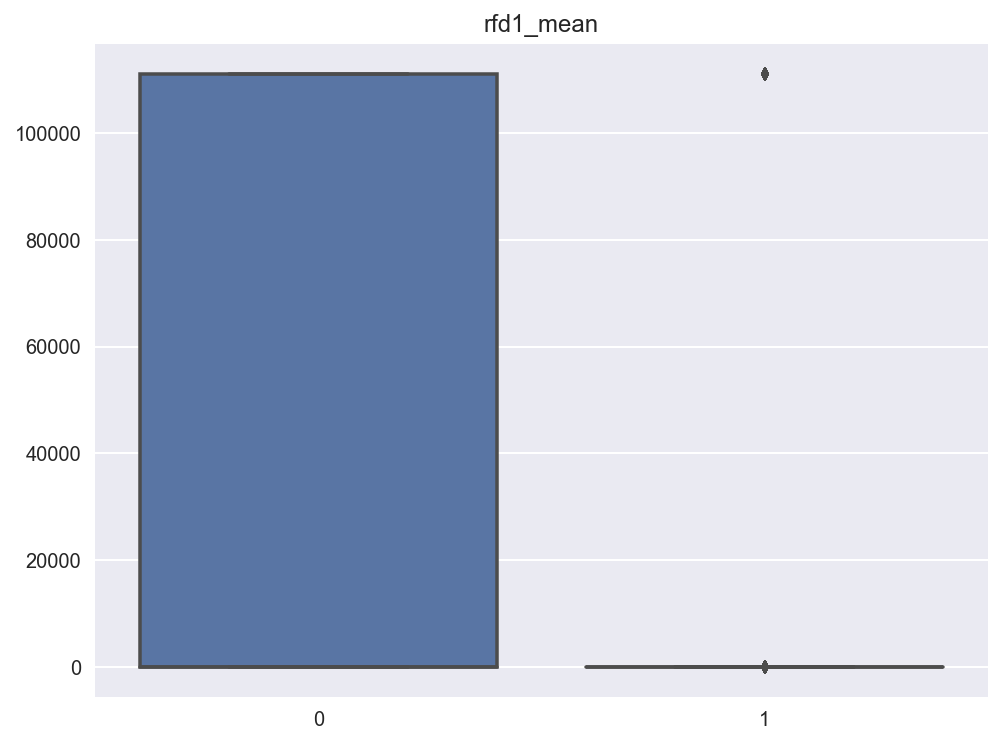

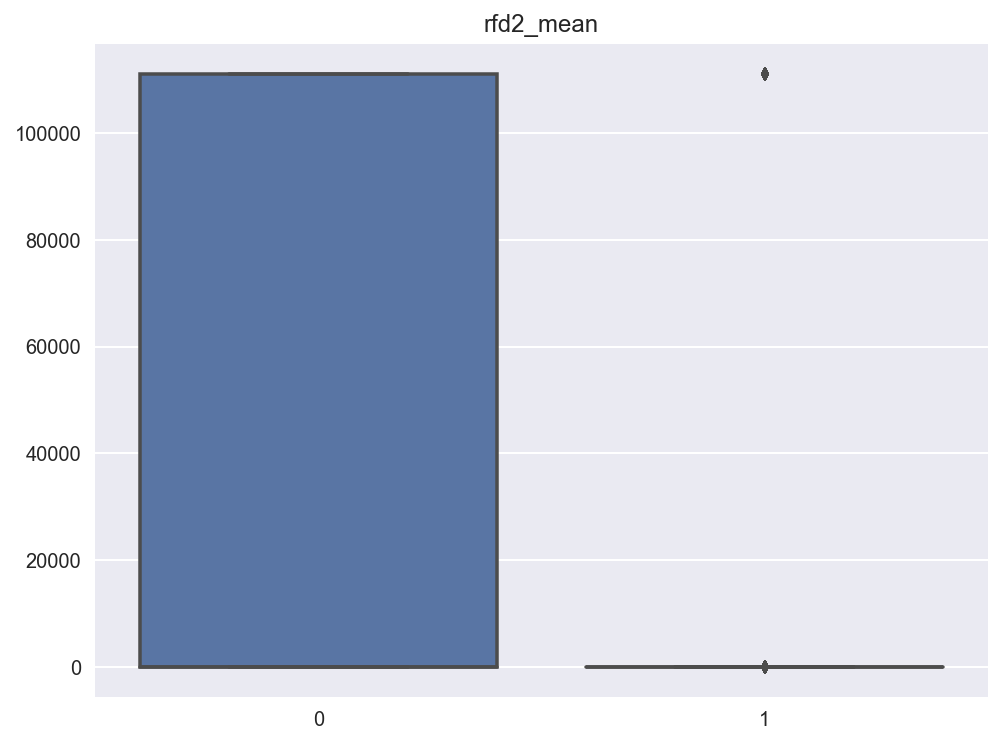

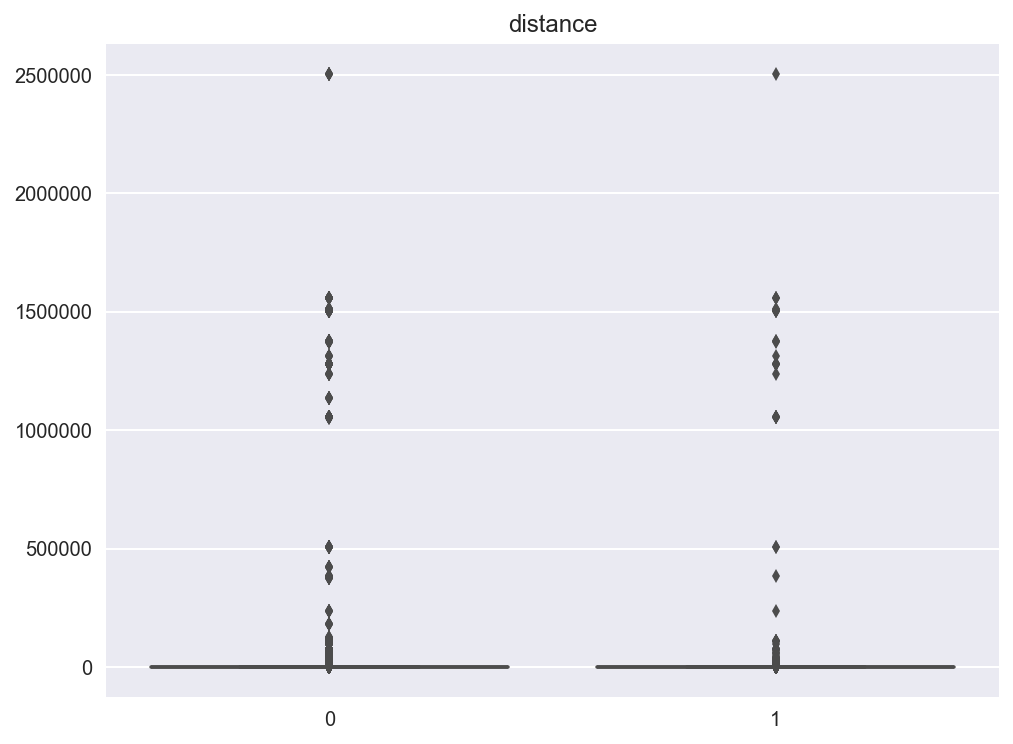

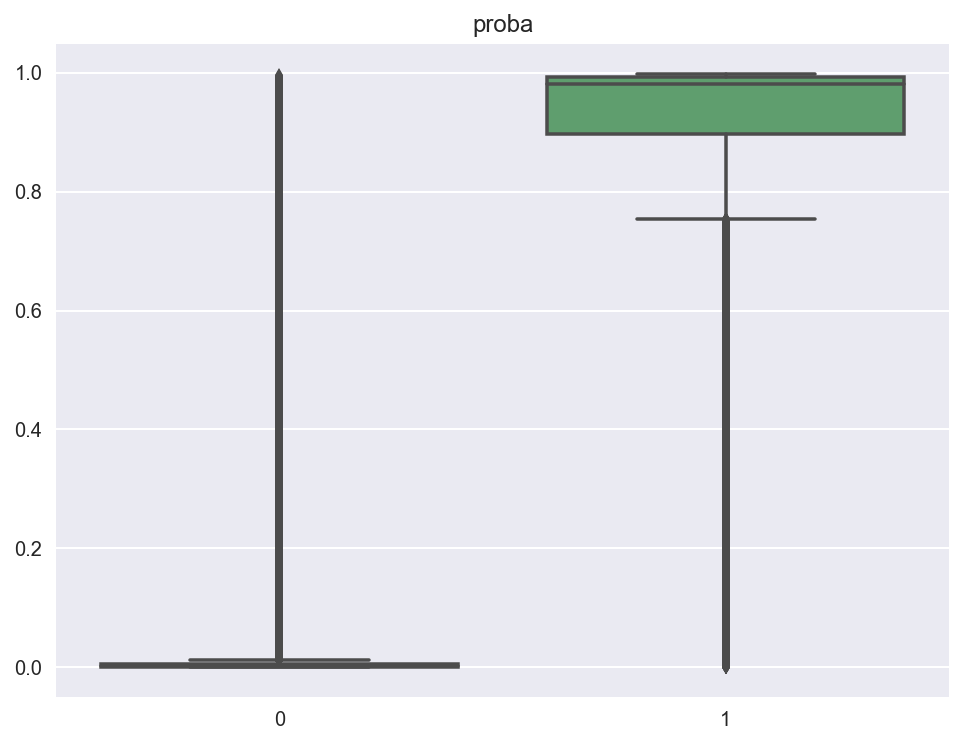

In [41]:
tmp_df=pd.concat((val_feat[feat_cols],val_label),axis=1).rename(columns={0:'label'})
true_idx=tmp_df[tmp_df.label==1].index
false_idx=tmp_df[tmp_df.label==0].index
for col in tqdm(feat_cols):
    plt.figure()
    sns.set({'figure.figsize':(8,6)})
    # 直方图
#     tmp_df.loc[true_idx,col].hist(bins=100,label='1')
#     tmp_df.loc[false_idx,col].hist(bins=100,alpha=0.4,label='0',color='r')
    # 箱型图
    sns.boxplot(data=[tmp_df.loc[false_idx,col],tmp_df.loc[true_idx,col]])
    plt.title(col)
    plt.legend()

## 模型训练

In [23]:
from sklearn.model_selection import ParameterGrid
import lightgbm as lgb

params = {
    'objective': ['binary'],
    'metric': ['binary_error'],
    'learning_rate':[0.05],
    'feature_fraction': [0.6],
    'max_depth': [12],
    'num_leaves':[180],
    'bagging_fraction': [0.6],
    'bagging_freq':[5],
    'min_data_in_leaf':[10],
    'min_gain_to_split':[0],
    'lambda_l1':[1],
    'lambda_l2':[1],
    'verbose':[0],
    'is_unbalance':[True]
}
params=list(ParameterGrid(params))

In [24]:
# 每个mall单独训练二分类
%%time
l=[]
ll=[]
for mall_id in tqdm(meta_df.mall_id.unique()):
    lgbtrain=lgb.Dataset(train[train_feat.mall_id==mall_id],label[train_feat.mall_id==mall_id])
    lgbtrain.set_feature_name(feat_cols)
    lgbval=lgb.Dataset(val[val_feat.mall_id==mall_id],val_label[val_feat.mall_id==mall_id],reference=lgbtrain)
    model = lgb.train(params[0], lgbtrain, num_boost_round=1000,valid_sets=lgbval,early_stopping_rounds=30) # early_stopping
    # 测试
    proba=model.predict(test[test_feat.mall_id==mall_id])
    ans=pd.DataFrame({'row_id':test_basic.loc[test_basic.mall_id==mall_id,'row_id'],'shop_id':test_basic.loc[test_basic.mall_id==mall_id,'shop_id'],'proba':proba})
    tmp=ans.sort_values('proba').groupby('row_id',as_index=False).tail(1)
    tmp=pd.merge(test_df.loc[test_df.mall_id==mall_id,['row_id']],tmp,on='row_id',how='left')
    tmp.fillna('s_4941',inplace=True)
    ll.append(tmp)
    # 验证
    proba=model.predict(val[val_feat.mall_id==mall_id])
    ans=pd.DataFrame({'row_id':val_basic.loc[val_basic.mall_id==mall_id,'row_id'],'shop_id':val_basic.loc[val_basic.mall_id==mall_id,'shop_id'],'proba':proba})
    tmp=ans.sort_values('proba').groupby('row_id',as_index=False).tail(1)
    tmp=pd.merge(x_val.loc[x_val.mall_id==mall_id,['row_id']],tmp[['row_id','shop_id']],on='row_id',how='left')
    tmp.fillna('s_4941',inplace=True)
    l.append(tmp)

SyntaxError: invalid syntax (<ipython-input-24-9117f33958fd>, line 2)

In [44]:
# 验证集acc
pd.merge(x_val[['row_id','shop_id']],pd.concat(l),on=['row_id','shop_id'],how='inner').shape[0]/x_val.shape[0] 
# proba+dis:0.9165989710262659
# no proba: dis:0.9106736114429524  dis_rank:0.9067393001067202 both：0.9111992481801819

0.9165989710262659

In [45]:
# 保存结果
result=pd.concat(ll)
print(result.shape)
result.to_csv('/Users/wangdexun/Downloads/result.csv',index=False,sep=',')

(483931, 3)


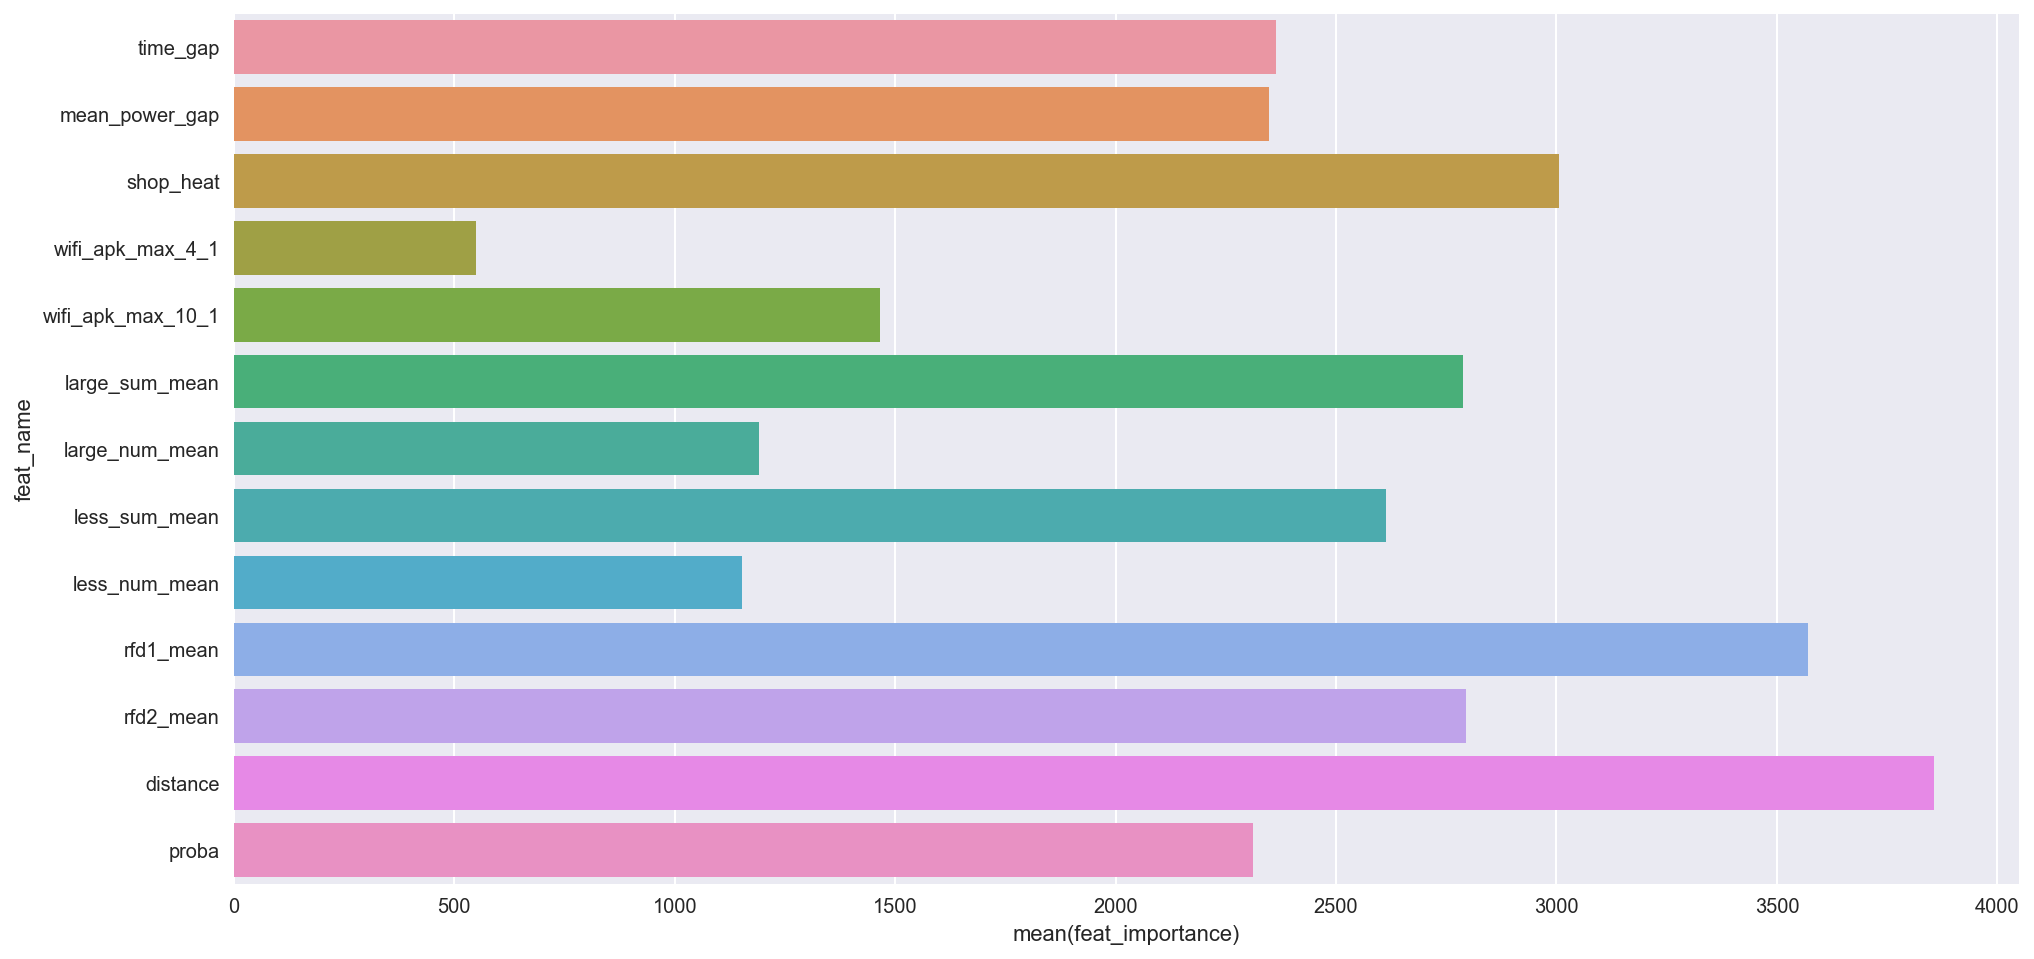

In [46]:
# 特征重要程度
sns.set({'figure.figsize':(16,8)})
sns.barplot(data=pd.DataFrame({'feat_name':train.columns,'feat_importance':model.feature_importance()}),x='feat_importance',y='feat_name')

In [25]:
######################################## 二分类一起训练 ########################################
lgbtrain=lgb.Dataset(train.values,label)
lgbtrain.set_feature_name(feat_cols)
model = lgb.train(params[0], lgbtrain, num_boost_round=150)

In [26]:
# 模型验证
proba=model.predict(val.values)
ans=pd.DataFrame({'row_id':val_basic['row_id'],'shop_id':val_basic['shop_id'],'proba':proba})
tmp=ans.sort_values('proba').groupby('row_id',as_index=False).tail(1)
tmp=pd.merge(x_val[['row_id','shop_id','mall_id']],tmp[['row_id','shop_id']],on='row_id',how='left')
tmp.fillna('s_4941',inplace=True)
print(len(tmp[tmp.mall_id=='m_7800'][tmp.shop_id_x==tmp.shop_id_y])/x_val[x_val.mall_id=='m_7800'].shape[0]) # 1920  7800
len(tmp[tmp.shop_id_x==tmp.shop_id_y])/x_val.shape[0] # 0.890

0.7069943289224953


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


0.8954142176773228

In [43]:
# 测试
proba=model.predict(test)
ans=pd.DataFrame({'row_id':test_basic['row_id'],'shop_id':test_basic['shop_id'],'proba':proba})
# 保存结果文件
tmp=ans.sort_values('proba').groupby('row_id',as_index=False).tail(1)
tmp=pd.merge(test_df[['row_id']],tmp[['row_id','shop_id']],on='row_id',how='left')
tmp.fillna('s_4941',inplace=True)
tmp.to_csv('result.csv',index=False,sep=',')